# **Predicting COVID-19 Transmission Risk**

**Introduction:**


We plan to help out Billy, who has recently lost his job due to COVID-19 and is trying to find a job in another country. He prefers to move to a country that will be safer, with fewer new COVID cases. 

We aim to help Billy answer the question: “How safe is it to move to country X?” by predicting the number of new cases per million. A lower number indicates a safer country with lower transmission risk. We will use a categorical variable “risk level”, that we created ourselves, to more easily interpret the numerical output of our prediction. 

We will use worldwide data collected over the past few months of the pandemic ([Ritchie 2020](https://ourworldindata.org/coronavirus-source-data)). This dataset contains many variables, but we will use population density, stringency index (a composite measure of government COVID-19 response), GDP per capita (economic output per person), hospital beds per thousand, and life expectancy as predictors. We narrowed the data down to consider only current data (from September 1st 2020 onwards), to accurately model the current coronavirus situation. We will predict the number of new cases per million, using our designated predictor variables, to inform Billy’s decision.



In [ ]:
#installing and loading in the required packages for running this file
install.packages("tidymodels")
install.packages("kknn")
install.packages("GGally")
install.packages("reshape2")
install.packages("shiny")

library(tidyverse)
library(tidymodels)
library(lubridate)
library(repr)
library(kknn)
library(GGally)
library(reshape2)
library(shiny)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘lhs’, ‘iterators’, ‘plyr’, ‘DiceDesign’, ‘globals’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘GPfit’, ‘foreach’, ‘hardhat’, ‘pROC’, ‘cli’, ‘dials’, ‘infer’, ‘magrittr’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘rstudioapi’, ‘tune’, ‘workflows’, ‘yardstick’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘igraph’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘reshape’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘fastmap’


── Attaching packages ───────

We have obtained our data from the 'Our World in Data' [Coronavirus Source Data](https://ourworldindata.org/coronavirus-source-data), which is collected in partnership with the University of Oxford and the Oxford Martin School, updated daily.

In [ ]:
#utilizng the github commit hash code in order to maintain the same running code throughout the lifespan of this file
url <- "https://raw.githubusercontent.com/owid/covid-19-data/fb73a3759b6691dc9a6f880353a37e70cd7ceb92/public/data/owid-covid-data.csv"
data <- read_csv(url)

#adding table title
h3("Table 1: Raw data from 'Coronavirus Source Data'")
head(data)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  iso_code = col_character(),
  continent = col_character(),
  location = col_character(),
  date = col_date(format = ""),
  icu_patients = col_logical(),
  icu_patients_per_million = col_logical(),
  hosp_patients = col_logical(),
  hosp_patients_per_million = col_logical(),
  weekly_icu_admissions = col_logical(),
  weekly_icu_admissions_per_million = col_logical(),
  weekly_hosp_admissions = col_logical(),
  weekly_hosp_admissions_per_million = col_logical(),
  total_tests = col_logical(),
  new_tests = col_logical(),
  total_tests_per_thousand = col_logical(),
  new_tests_per_thousand = col_logical(),
  new_tests_smoothed = col_logical(),
  new_tests_smoothed_per_thousand = col_logical(),
  tests_per_case = col_logical(),
  positive_rate = col_logical()
  # ... with 1 more columns
)
ℹ Use `spec()` for the full column specifications.


Warning message:
“237723 parsing f

Shiny tags cannot be represented in plain text (need html)

iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,⋯,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2019-12-31,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-01,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-02,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-03,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-04,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-05,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498


To begin, we are going to be selecting all of the columns which we believe will be of use for this analysis. This includes columns such as 'new_cases_smoothed_per_million', 'stringency_index', and 'location'. We will go further in depth later within this analysis on the rational behind why we choose all of our predictors, what they each mean, and why they will be of usage for this analysis.

To reduce confusion, the 'new_cases_per_million' column represents the number of new cases per million recored each day within a certain country, where the 'new_cases_smoothed_per_million' column represents the rolling average over the week of new_cases_per_million in order to account for days in which a country does not preform any tests. For the purpose of this analysis, we will be visualizing through the 'new_cases_smoothed_per_million' in order to represent a smoothed out state of a country. However, within our predictive model, we will be using 'new_cases_per_million' as when Billy is looking to predict the number of cases on November 17th, he will be predicting a new day value, instead of a rolling weekly average. If we were to predict a rolling average, namely, 'new_cases_smoothed_per_million', it would be averaging accross multiple prediction dates, even though we will only be giving it one set of predictors for one day.

In [ ]:
# this is our exploratory data table, depicting our predictors of interest
newdata <- data %>%
  select(location, date, total_cases, new_cases, new_cases_per_million ,new_cases_smoothed_per_million, stringency_index, population_density, gdp_per_capita, hospital_beds_per_thousand, life_expectancy) %>% 
  filter(date >= as.Date("2020-09-01"), date <= as.Date("2020-11-16")) %>% #filter date after september to avoid overplotting
  filter(new_cases_smoothed_per_million >= 0 & new_cases_smoothed_per_million < 1000) %>% #stating our upper and lower boundries
  drop_na() #we are dropping our NA values due to the fact that we can not preform KNN regression on values which do not exist %>%

#adding table title
h3("Table 2: Preliminary data filtering")
head(newdata)

Shiny tags cannot be represented in plain text (need html)

location,date,total_cases,new_cases,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,population_density,gdp_per_capita,hospital_beds_per_thousand,life_expectancy
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,2020-09-01,38196,34,0.873,0.462,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-02,38205,9,0.231,0.492,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-03,38243,38,0.976,0.429,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-04,38288,45,1.156,0.583,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-05,38304,16,0.411,0.602,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-06,38324,20,0.514,0.664,21.3,54.422,1803.987,0.5,64.83


One thing that can be noted is that we decided to filter the date to only take observations from dates past September, 1st, 2020, due to the fact that we had over 70,000 observations within the original data set, thus rendering our visualizations quite difficult to properly see. Furthermore, we believe that in taking recent cases, that being of past September, it will give a more accurate representation of the present state of the pandemic and will allow for a better end result within our predictive model. As for stopping data collection on November 16th, 2020, that is because Billy will be booking his flight on November 17th, 2020, therefore, he will be utillizing all the past data in order to predict the rate of infection on the day in which he makes his final decision.

In regards to why we have capped off the 'new_cases_smoothed_per_million' at 1000 new cases per million, we have done this for mainly two reasons. The first reason is because most countries around the world are generally reaching maximum numbers of around 1000 new cases per million, therefore it is unnecessary for our analysis to include value much higher than that. The second reason is that for countries which have an extremely small population, such as Vatican City, which has a population of 825 as of 2019, counting the new cases per million, per day, becomes extremely disproportionate to the rest of the world, and will subsequently skew the labels within the next cell. For example, if Vatican City were to record 7 new cases on a certain day, the corresponding new_cases_smoothed_per_million would be approximately 2500 due to scaling up for its miniscule population size, which is much higher than any of the more populated and habited countries. For the purpose of our analysis, this will skew the proportions of our labels to be extreamly weighted towards the lower spectrum, and off the record, Billy is not planning on replacing the Pope for work anytime soon.

In [ ]:
# library(mice)

#simple imputation: (will replace NA values with the mean of each column)
# newdata$life_expectancy[which(is.na(newdata$life_expectancy))] = mean(newdata$life_expectancy, na.rm = TRUE)

# model_data <- newdata %>%
#     select(-location, -date, -total_cases, -new_cases_smoothed_per_million) %>%
#     drop_na() 

# nrow(model_data)
# summary(model_data)

# methods(mice)
#mice imputation/chained imputation:

# imp_func <- mice(model_data, m = 1, method = "pmm", maxit = 20)



In [ ]:
#choosing which imputation iteration got the most accurate imputations

# summary(model_data$hospital_beds_per_thousand)
# head(imp_func$imp$hospital_beds_per_thousand)
# summary(imp_func$imp$hospital_beds_per_thousand)

#chooses the third df that was spit out; choose the one that deviates the least from your mean
# clean_data <- complete(imp_func, 1)
# summary(clean_data)
# head(clean_data)

In [ ]:
# knn_data <- newdata %>%
#   select(-continent, -location, -date) %>%
#     select(handwashing_facilities) %>%
#       lapply(as.numeric)

# khan.imputed <- knn_data %>%
#   impute.knn(rowmax = 1, colmax = 1, as.matrix(knn_data))


In order to quantify the global state of the pandemic, we will be creating labels for certains bins in which each country falls in on a certain date. For example, we will be cutting the 'new_cases_smoothed_per_million' values into 5 evenly split bins such that each value resulting to each observation has a corresponding factor label attached to it. This will make it easier to compare the state of each country at the end of our analysis, as Billy will need a reference point to compare to other countries instead of simply getting a predictive number on the rate of infection, as he will not know if this is good or bad if he does not have a reference point.

Note: We are using 'new_cases_smoothed_per_million' instead of 'new_cases_per_million' for the labels as we do not want days in which a country does not preform any tests to be labeled as Very Low risk, where the next day they record the previous two days worth of data as Very High.

In [ ]:
#adding labels to ranges of risk
risk_level <- newdata$new_cases_smoothed_per_million %>%
  cut(5, labels = c("Very Low", "Low", "Moderate", "High", "Very High"))

newdata$risk_level <- risk_level
head(risk_level, 0)

#counting how many of each labels there are within our dataset
counts <- newdata %>%
  group_by(risk_level) %>%
  summarize(counts=n())

#adding table title
h3("Table 3: Counting number of labels")
head(counts)


factor(0)
Levels: Very Low Low Moderate High Very High

`summarise()` ungrouping output (override with `.groups` argument)



Shiny tags cannot be represented in plain text (need html)

risk_level,counts
<fct>,<int>
Very Low,10034
Low,653
Moderate,279
High,95
Very High,52


Through this count, we can see that approximatly only 0.4% of the recorded days of the pandemic from September 1st, to November 16th, are recorded as Very High risk. This is independent of the country that each was recorded in, as this is simply to quantify the variation within the severity of the pandamic across the world. The bins for the data were split evenly up as follows depending on their 'new_cases_smoothed_per_million': 

1.   Very Low: (0,198)
2.   Low: (198,395)
3.   Moderate: (395,593)
4.   High: (593,790)
5.   Very High: (790,989)

Below, we have pulled the data for Switzerland as an example in order to see whether our risk_level labels have been added properly and whether they accurately correspond to each country's daily observations. Furthermore, we have generated a test_plot in order to see how the 'new_cases_smoothed_per_million' differ with the date the observation was taken, with each value corresponding to a certain risk_level.

Note: We will not only be predicting results from Switzerland, this is only a visualization for Switzerland as it is a good example of rate of infection over time. We can not visually represent all 195 countries within their own seperate plot.

In [ ]:
# this is just for testing and visualizing our data within a table
test <- newdata %>%
  arrange(desc(new_cases_smoothed_per_million)) %>%
    filter(location == "Switzerland")

#adding table title
h3("Table 4: Filtered Switzerland (example usage only)")
head(test)

Shiny tags cannot be represented in plain text (need html)

location,date,total_cases,new_cases,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,population_density,gdp_per_capita,hospital_beds_per_thousand,life_expectancy,risk_level
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Switzerland,2020-11-07,211160,9359,1081.388,947.999,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-08,211160,0,0.000,947.999,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-09,211160,0,0.000,947.999,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-06,201801,10098,1166.776,944.880,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-05,191703,10043,1160.421,932.714,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-03,175570,21842,2523.739,906.040,50.93,214.243,57410.17,4.53,83.78,Very High


Shiny tags cannot be represented in plain text (need html)

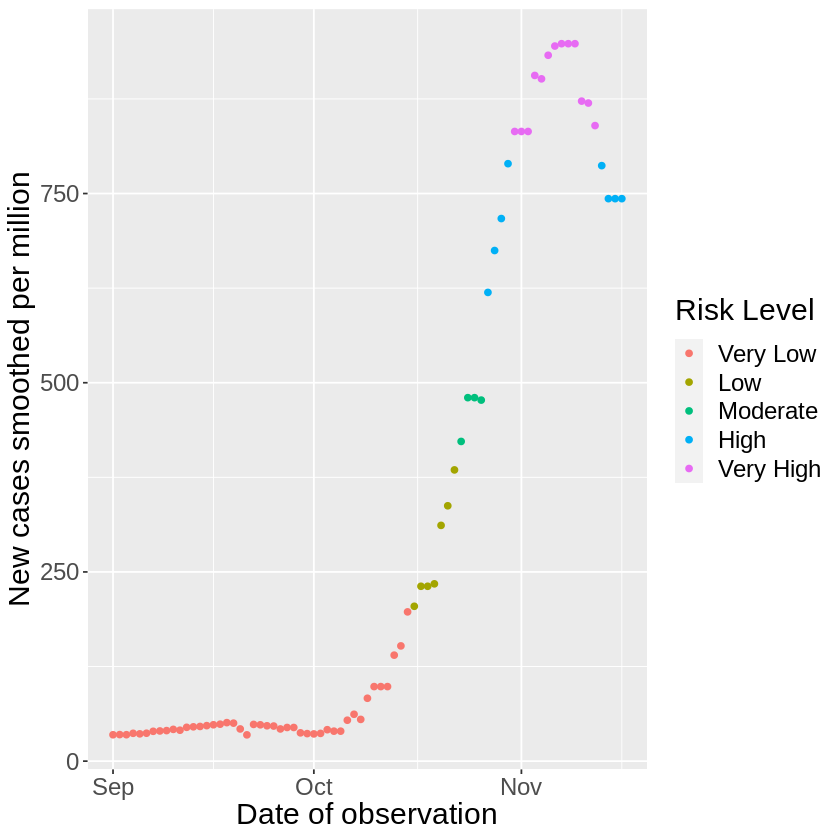

In [ ]:
#add options to size plot properly

# our preliminary exploratory plot - to visualize how risk level changes over time in a given country 
test_plot <- newdata %>%
  filter(location == "Switzerland") %>%
  ggplot(aes(x=date, y=new_cases_smoothed_per_million, colour = risk_level)) + 
  geom_point() + 
  labs(x = "Date of observation", y = "New cases smoothed per million", colour = "Risk Level") +
  theme(text = element_text(size = 18))

#adding figure title
h3("Figure 1: Number of cases smoothed per million against Date of observation")
test_plot

As can be seen above, we can concure that the risk_level labels have been added properly such that they differ depending on the quantity of 'new_cases_smoothed_per_million' there are within a certain country. Furthermore, since we are using 'new_cases_smoothed_per_million' instead of 'new_cases_per_million' due to the reasons stated at the start of this analysis, our test_plot curve is largely smooth, and averages out days when no tests were preformed. 

From here, we will begin with the data analysis/prediction preprocessing that we will be utilizing for this project. We will be splitting our data into a 75:25 training-testing split. We belive that this is the best possible split as from the previous label counter, we can see that we have ~50 of the 'Very High' risk label, therefore in retaining around 1/4 for testing data, we are able to take approximatly ~10. Something to note is that here, we are splitting the data based on the 'new_cases_per_million', since it is what we will be using to predict as opposed to splitting it based on the risk_level. In retrospect, this should not change the way in which the data is split if it were to be split along risk_level since it is based on the new cases column anyway, however, to maintain continuity we split our data through 'new_cases_per_million'.  

In [ ]:
set.seed(1234) 
#splitting into testing and training data
covid_split <- initial_split(newdata, prop = 0.75, strata = new_cases_per_million)
covid_training <- training(covid_split)
covid_testing <- testing(covid_split)

#counting labels for training data
counts_train <- covid_training %>%
  group_by(risk_level) %>%
  summarize(counts=n())

#adding table title
h3("Table 5: Label counts for training data") 
head(counts_train)

#counting labels for testing data
counts_test <- covid_testing %>%
  group_by(risk_level) %>%
  summarize(counts=n())

#adding table title
h3("Table 6: Label counts for testing data") 
head(counts_test)

`summarise()` ungrouping output (override with `.groups` argument)



Shiny tags cannot be represented in plain text (need html)

risk_level,counts
<fct>,<int>
Very Low,7511
Low,505
Moderate,217
High,65
Very High,39


`summarise()` ungrouping output (override with `.groups` argument)



Shiny tags cannot be represented in plain text (need html)

risk_level,counts
<fct>,<int>
Very Low,2523
Low,148
Moderate,62
High,30
Very High,13


Our data splitting was successfull and we can begin to do the preliminary data preprocessing. However, before we are able to create our recipe, we must determine which of the data columns within our data set will be best suit to act as our predictors. To do this, we can create a scatterplot matrix of all the different predictors we are thinking of using, and subsequently determine their correlation to our predicting variable.

Shiny tags cannot be represented in plain text (need html)

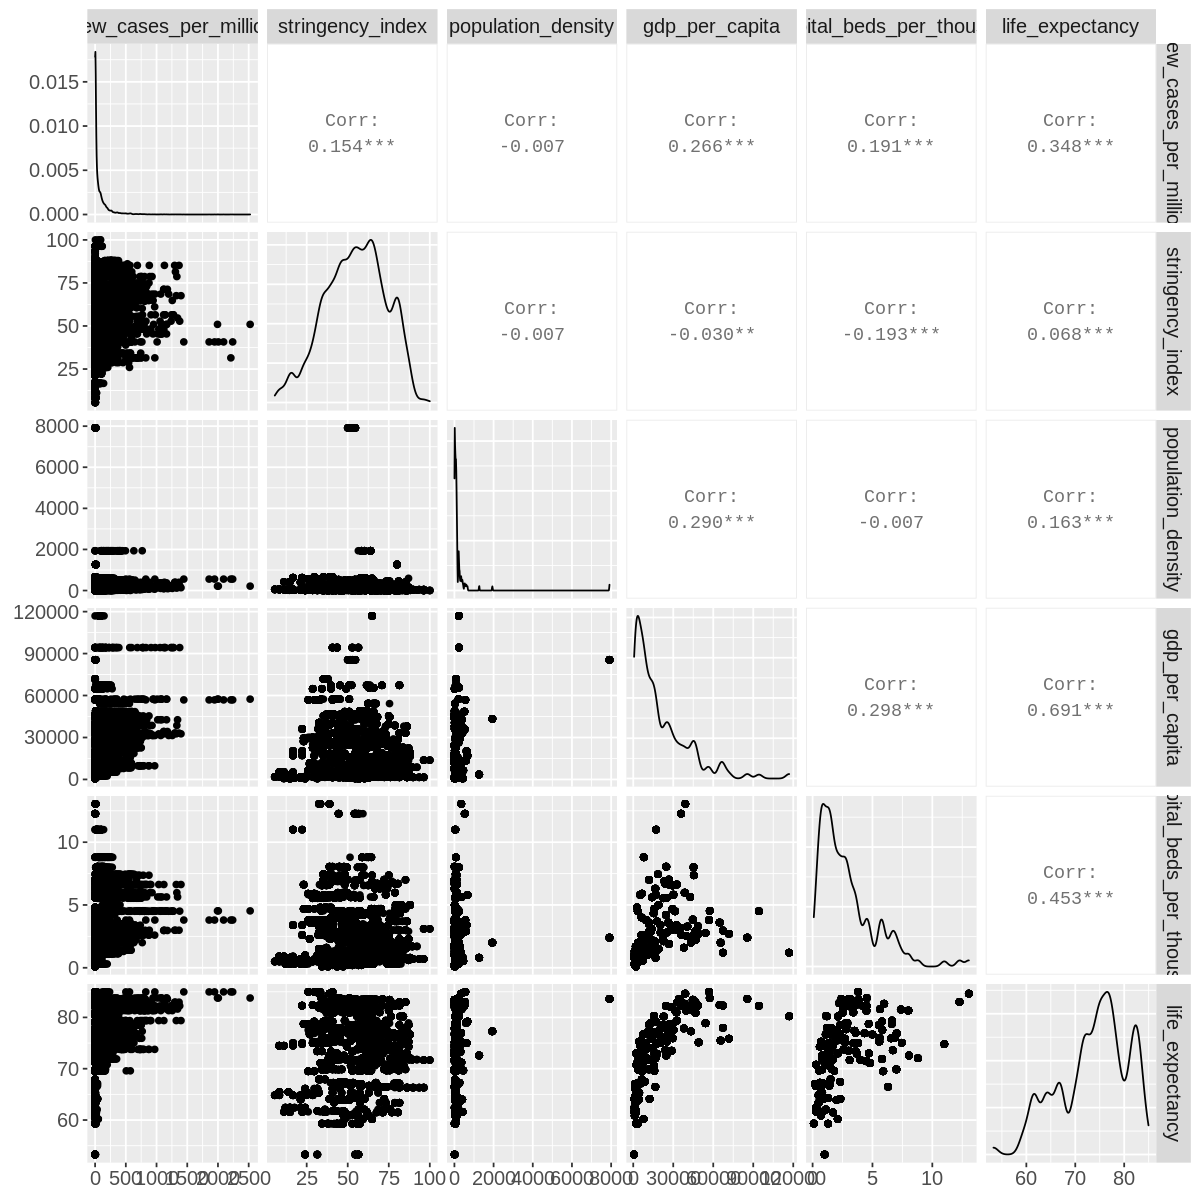

In [ ]:
#options to resize plot into a readable size
options(repr.plot.width = 10, repr.plot.height = 10)

#creating a scatterplot matrix through the ggpairs() function
plot_pairs <- newdata %>% 
  select(new_cases_per_million, stringency_index, population_density, gdp_per_capita, hospital_beds_per_thousand, life_expectancy) %>% 
  ggpairs() + 
  theme(text = element_text(size = 15))

#adding figure title
h3("Figure 2: Scatterplot matrix for potential predictors")
plot_pairs

Through this scatterplot matrix, we are comparing many different potential predictors, which we will explane their significance in the following cells. stringency_index refers the severity of each countries lockdown policies, for example, a higher stringency_index represents a country with extreme social restrictions and regulation such as China or Vietnam. population_density is the density of each countries population averaged over their substates and cities. gdp_per_capita, or otherwise known as per capita income or average income is the masure of the average income earned per person in a given country within a given year. hospital_beds_per_thousand is the measure of how many hospital beds are available per one thoussand people averaged across a country. Finally, life_expectancy most self explanatory, namely referring to the average age that citizens within the country are expected to live to. 

Most of our wanted predictors have a correlation coefficient of above 0.25, such as gdp_per_capita, hospital_beds_per_thousand, life_expectancy, and stringincy_index. Eventhough this is not the strongest correlation coefficient, we believe that with enough predictors, it will be sufficient in predicting the new_cases_per_million within a reasonable margin. However, the population_density predictor has a correlation coefficient of around -0.004, which signifies that it is not inherently proportional to the new_cases_per_million. Normally, it would be best to remove and continue without this predictor, however, through logistical reasoning, we believe that it in fact would be beneficial to keep this predictor due to the fact that it will aid the model in selecting values which originate from similar countries to the one being predicted. 

Logistically, we chose our 5 predictors: stringency_index, population_density, gdp_per_capita, hospital_beds_per_thousand, life_expectancy, for several different reasons. Primarily, stringency_index will be directly proportional to the rate of infection within a given country as it referres to the government regulations and restrictions that are on the population, therefore, a higher value should indicate to lower rates of infection. gdp_per_capita will be relevant since it is an indication as to the amount of wealth which is distributed across the given population. If a country has a lower gdp_per_capita, then it most likely is less developed and therefore has less acess to advanced medical care, thus decreasing the rate at which people are cured and increasing transmission rate. Similarly, hospital_beds_per_thousand is close in importance to gdp_per_capita, as the more hospital beds there are available, the more people are able to be cured and subsequently the virus can be contained. Finally, life_expectancy is the final predictor as it is an indication to the level of and advancements of healthcare within a certain country. As we know, older generations are more susceptible to illnesses and disease, therefore, if the life_expectancy of a population is higher, it often correlates to an advanced healthcare system such as that of Japan. 

Note: Each predictor on its own is not solely enough to predict the rate of infection as they all depend on one another. For example, a country may have a very high life expectency, indicating high level of heathcare, however, if their stringency_index is very low, then many of those elders can get infected quite easily, driving up the overall rate of infection. Due to this, it is very important that we utilize a wide variety of predictors, as one singular predictor can depend on many of the other predictors in order to gain the full picture.

In [ ]:
set.seed(1234) 
# selecting relevant predictors
covid_predictors <- covid_training %>%
  select(new_cases_per_million, stringency_index, population_density, gdp_per_capita, hospital_beds_per_thousand, life_expectancy)

# creating a recipe 
recipe <- recipe(new_cases_per_million ~., data = covid_predictors) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

#conducting 5-fold cross validation to determine the best parameter for number of neighbors
cross_validation <- vfold_cv(covid_predictors, v = 5, strata = new_cases_per_million)

#knn model specifications for knn-regression while tuning for 'k'
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("regression")

recipe
knn_tune

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Once we have chosen our relevant predictors, we created our recipe in preparation for the model specifications. The recipe scaled and centered all of the predictors for the simple reason that we are utilizing KNN-regression, and it relies upon the Euclidean distance away from other neighboring points. Furthermore, we will be preforming 5-fold cross validation in order to determine the best value of 'k', which I will explain within the following cell. Since we are preforming cross validation in order to find the optimal value of 'k', when creating our KNN-regression model specification, we must tune the number of neighbors such that we can later utilize the tune_grid() function to calculate the RMSE within each value of 'k'.

Now that a recipe and model specification have been created, we can push them through a workflow such that we are able to calculate the resulting RMSE for 'k' values from 1 to 20. Due to the fact that the accuracy within larger values of 'k' is known to deterorate the more neighbors a model uses, we will only be calculating the first 20 neighbors as these values will be the most practical for our usage.

In [ ]:
set.seed(1234)

#utilizing a workflow in order to determing the RMSE within each value of k 
workflow <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = cross_validation, grid = 20) %>%
    collect_metrics()

#adding table title
h3("Table 7: Metrics from workflow") 
head(workflow)


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice



Attaching package: ‘vctrs’


The following object is masked from ‘package:dplyr’:

    data_frame


The following object is masked from ‘package:tibble’:

    data_frame




Shiny tags cannot be represented in plain text (need html)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,118.1746248,5,2.44114865,Preprocessor1_Model01
1,rsq,standard,0.4596444,5,0.03319675,Preprocessor1_Model01
2,rmse,standard,102.7504449,5,4.37861765,Preprocessor1_Model02
2,rsq,standard,0.5609160,5,0.04353141,Preprocessor1_Model02
3,rmse,standard,99.4174642,5,4.29831831,Preprocessor1_Model03
3,rsq,standard,0.5788306,5,0.03230557,Preprocessor1_Model03


We will be calculating the optimal 'k' value based on its inherent RMSE that it calculated from our cross validation step. For our purposes, the RMSE referres to the error within the number of cases that the model predicts. For example, as can be seen within the first row of the metrics, a neighbor of 1 is able to predict within an accuracy of +- 118.1746 cases, therefore, for every prediction, the model will generally be within 118.17 cases of the actual value if it were utilizing 1 neighbor. The 118.17 RMSE is not written in stone, however, it is the value in which most (~95%) of the predictions are going to be within.

Shiny tags cannot be represented in plain text (need html)

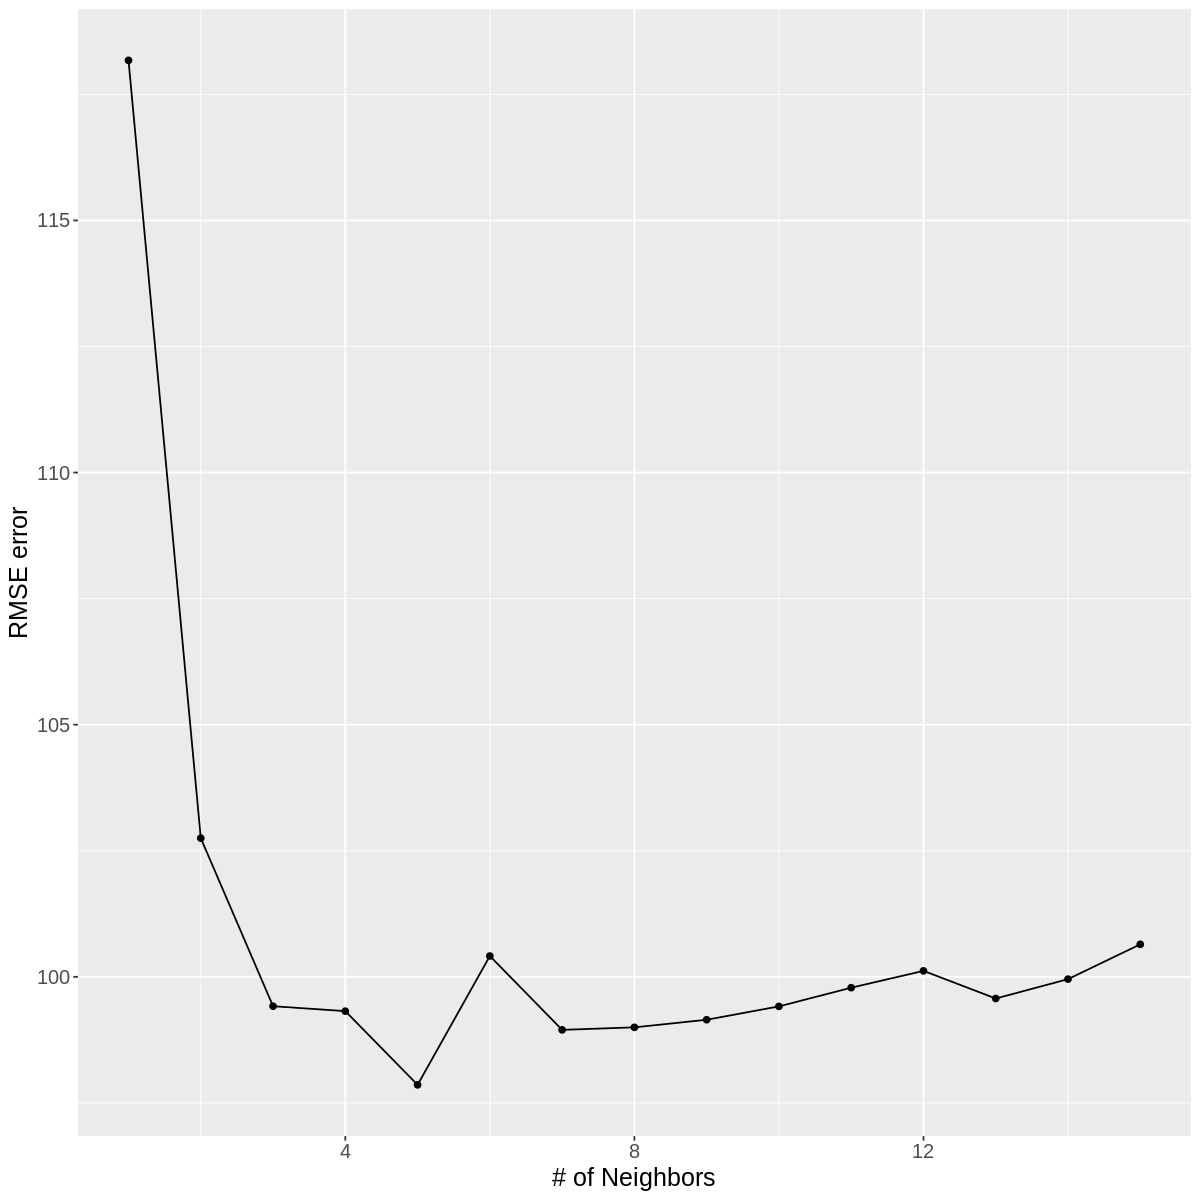

In [ ]:
#options to resize plot into a readable size
options(repr.plot.width = 10, repr.plot.height = 10)

#filtering out the smallest value of RMSE to use for k
best_fit <- workflow %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean)) %>%
  pull(neighbors)

#plot of the RMSE against k value
bestk <- workflow %>% 
    filter(.metric == "rmse") %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "# of Neighbors", y = "RMSE error") +
    theme(text = element_text(size = 15))

#adding figure title
h3("Figure 3: RMSE per Neighbor relationship")
bestk

As can be seen above, we calculated the optimal value of 'k' through taking the minimum of all the RMSE values for all dfiferent values of 'k'. This allowed us to filter for the number of neighbors with the lowest error, which turned out to be 5 neighbors. From the plot, we can see that the inherent error within different values of 'k' often flucuated, for example, there was an extremely large drop in RMSE from 1 to 2 neighbors, however, from 3 to 4 the RMSE barely flucuated. This signifies that our model is quite sensitive to the number of neighbors that it utilizes, where 5 is seemlingly the optimal quantity to achieve the lowest RMSE. 

Now that we have the optimal number of neighbors for our model, we are able to subsequently determine the overall RMSPE of our model when predicting on our testing data. We can do this by creating a new model specification where it utilizes the optimal 'k' value, and therefore use it to predict over the testing data.

In [ ]:
#optimized KNN regression specification with optimal 'k' value
optimized_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_fit) %>%
      set_engine("kknn") %>%
      set_mode("regression")

#new workflow with new model specification, fitted to training data
optimized_workflow <- workflow() %>%
  add_model(optimized_knn_spec) %>%
  add_recipe(recipe) %>%
  fit(data = covid_training)

#predicting on testing data
testing_comparison <- optimized_workflow %>%
  predict(covid_testing) %>%
  bind_cols(covid_testing)

#collecting the error within our model 
metrics <- testing_comparison %>%
  metrics(truth = new_cases_per_million, estimate = .pred) 

#adding table title
h3("Table 8: RMSPE for 5 Neighbors") 
head(metrics)

Shiny tags cannot be represented in plain text (need html)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,94.8081364
rsq,standard,0.6062277
mae,standard,32.0845840


As we can see, the resultant RMSPE withon our model is approximatly ~95.0, which signifies that for every prediction that it makes, it will generally be within +-95.0 cases above or below the true value. Again, this is not a condition of the model, however, we can be confident that around 95% of the predictions will fall within this error range. This error is not exactly as small as we would have hoped, however, for the purposes of this analysis this error is within reasonable margin. This is due to the fact of how we have cut our labels within the start of the analysis. Since every label is approximatly 200 units apart, namely, there is a 200 new_cases_smoothed_per_million difference between each interval, an error value of approximatly ~95.0 will not inherently change the label from one to another. At the worst case scenerio, the label may be shifted one ranking up or down, for example, if we predict a value of 80 new_cases_per_million, if we imagine the error within our model to be at is maximum, then at most the value is able to be 175 new_cases_per_million, which is still within the 'Low' boundry instead of the 'Very Low' boundry that we defined near the beginning. 

Since this is the margin of error within our model, it is the generalized largest possible error value within our prediction, therefore we are able to compare our predictions on the testing data set against their true values. One important fact to note is that I have utilized the 'new_cases_per_million' values when creating the average quantity of cases per country within the given time frame. This is because since we are inherently predicting 'new_cases_per_million' within one day, we are only able to directly compare the values to others within the same category, namely, comparing it to the mean of all the 'new_cases_per_million' within the given dataframe.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Shiny tags cannot be represented in plain text (need html)

location,prediction,true_value,error
<chr>,<dbl>,<dbl>,<dbl>
Mexico,29.31052000,38.24505000,8.93453000
Poland,129.59650526,183.33563158,53.73912632
Cambodia,0.02905263,0.01894737,0.01010526
Belarus,22.98425000,41.72912500,18.74487500
Japan,4.31078462,6.76084615,2.45006154
Pakistan,2.52326923,3.35265385,0.82938462
Cape Verde,163.37813636,140.94481818,22.43331818
Sweden,15.07040000,152.39676190,137.32636190
Bulgaria,138.94713333,211.09214286,72.14500952


Using location as id variables



Shiny tags cannot be represented in plain text (need html)

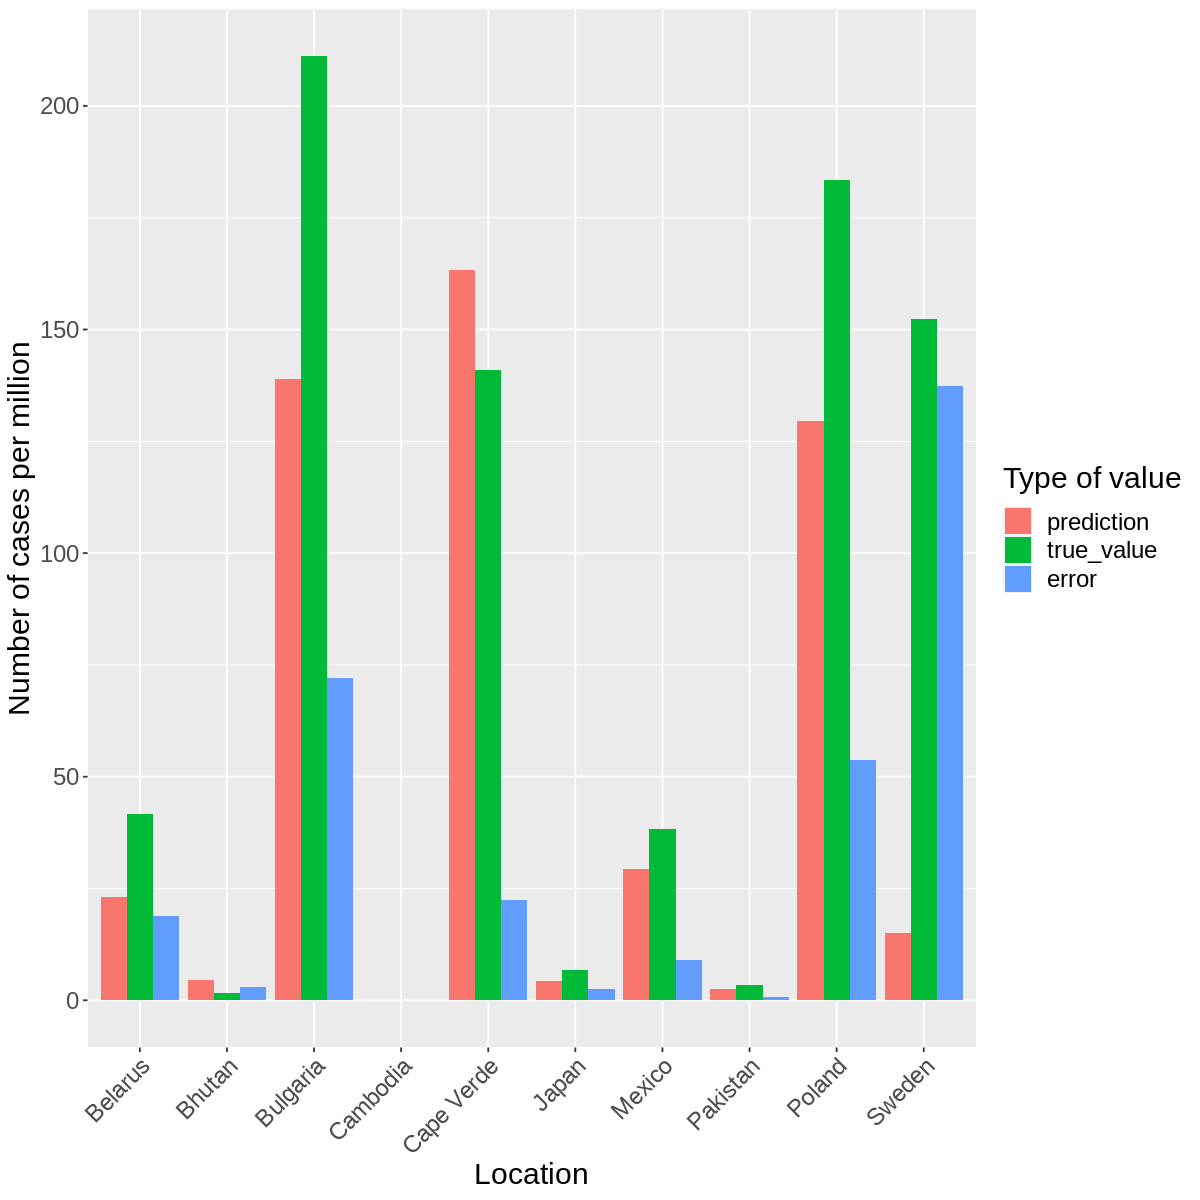

In [ ]:
#setting new seed for the sample_n() function
set.seed(1994)

#creating an average prediction per country to compare
mean_prediction_per_country <- testing_comparison %>%
    group_by(location) %>%
    summarize(prediction = mean(.pred))

#creating an average quantity of cases per country to compare
mean_newcases_per_country <- testing_comparison %>%
    group_by(location) %>%
    summarize(true_value = mean(new_cases_per_million)) %>%
    select(-location)

#binding columns in order to visually compare, and taking the difference with a random sample of 6
comparison_table <- bind_cols(mean_prediction_per_country, mean_newcases_per_country) %>%
  mutate(error = abs(true_value - prediction)) %>%
  sample_n(10)

#adding table title
h3("Table 9: Comparing mean prediction value against mean true value")   
comparison_table

#options to resize plot into a readable size
options(repr.plot.width = 10, repr.plot.height = 10)

#bar graph of prediction against true value
comparison_table_bar <- comparison_table %>%
  melt() %>%
  ggplot(aes(x = location, y = value, fill = variable)) + 
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Location", y = "Number of cases per million", fill = "Type of value") + 
  theme(text = element_text(size = 18), axis.text.x = element_text(angle = 45, hjust = 1))

#adding figure title
h3("Figure 4: Quantifying true values against predicted value and error")
comparison_table_bar

As we can see above, we can compare the true_value of the average new_cases_per_million of a given country along with its corresponding average prediction of the same country. Eventhough our model holds an RMSPE value of around +-95.0, when we take a random sample of 10 rows from our comparison table, it is evident that most of the predictions lie within a far smaller margin than 95.0 cases. This displays the inherent accuracy of our model, as eventhough the generalized maximum error is 95.0, we can see that most of the prediction values lie well within this margin of error. This is quite a pleasant suprise as I was expecting a far worse prediction for any random 10 samples within the comparision table. However, we can not ignore the difference of Sweden which is around ~137.0 cases. This is inherently fine since the RMSPE is the generalized error within the model, and since we can see that 9 of the 10 values lie within the margin, the error for Sweden represents the slim quantities of values which are slightly outside of the predetermined RMSPE. Through this information, we can conclude that our model has an RMSPE of ~95.0, however, most of its predictions fall well within that error margin, and thus we can predict with a relatively high degree of accuracy.

With all of these preliminary steps out of the way, we can finally predict the new_cases_per_million of each of the 5 countries Billy wishes to move to for work: Austria, Switzerland, Japan, Denmark, and United Arab Emirates. Due to the fact that the current date is November 16th, 2020, Billy wishes to predict the values today such that is he able to book his flight for tomorrow, therefore, Billy needs to find the relevant predictor information online in order for him to successfully predict his values. After a couple minutes of searching online, he constructs a tibble with all of the relevant observations needed for his prediction.

In [ ]:
# observations <- data %>%
#     filter(date == as.Date("2020-11-17")) %>%
#     select(location, date, stringency_index, population_density, gdp_per_capita, hospital_beds_per_thousand, life_expectancy) %>% 
#     filter(location == "United Arab Emirates")
# head(observations)

# observations for November 17th, 2020, of austria, Switzerland, japan, Denmark, United Arab Emirates
new_obs_austria <- tibble(location = "Austria", stringency_index = 75, population_density = 106.749, gdp_per_capita = 45436.69, hospital_beds_per_thousand = 7.37, life_expectancy = 81.54)
new_obs_switzerland <- tibble(location = "Switzerland", stringency_index = 50.93, population_density = 214.243, gdp_per_capita = 57410.17, hospital_beds_per_thousand = 4.53, life_expectancy = 83.78)
new_obs_japan <- tibble(location = "Japan", stringency_index = 38.89, population_density = 347.778, gdp_per_capita = 39002.22, hospital_beds_per_thousand = 13.05, life_expectancy = 84.63)
new_obs_Denmark <- tibble(location = "Denmark", stringency_index = 54.63, population_density = 136.52, gdp_per_capita = 46682.51, hospital_beds_per_thousand = 2.5, life_expectancy = 80.9)
new_obs_United_arab_emirates <- tibble(location = "United Arab Emirates", stringency_index = 45.37, population_density = 112.442, gdp_per_capita = 67293.48, hospital_beds_per_thousand = 1.2, life_expectancy = 77.97)

new_obs_all <- rbind(new_obs_austria, new_obs_switzerland, new_obs_japan, new_obs_Denmark, new_obs_United_arab_emirates)

#adding table title
h3("Table 10: Billy's desired country observations") 
new_obs_all



Shiny tags cannot be represented in plain text (need html)

location,stringency_index,population_density,gdp_per_capita,hospital_beds_per_thousand,life_expectancy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Austria,75.00,106.749,45436.69,7.37,81.54
Switzerland,50.93,214.243,57410.17,4.53,83.78
Japan,38.89,347.778,39002.22,13.05,84.63
Denmark,54.63,136.520,46682.51,2.50,80.90
United Arab Emirates,45.37,112.442,67293.48,1.20,77.97


Now that Billy has all of his predictors, he is able to run them through the model we have created and return his final results. Additionally, the labels will be added to the final predictions in order to qualitatively compare the predicted risk_level of each country Billy wishes to visit.

Shiny tags cannot be represented in plain text (need html)

location,.pred,prediction_risk_level
<chr>,<dbl>,<fct>
Japan,4.4166,Very Low
United Arab Emirates,87.4384,Very Low
Denmark,138.6348,Very Low
Austria,566.3974,Moderate
Switzerland,1110.9214,Very High


Shiny tags cannot be represented in plain text (need html)

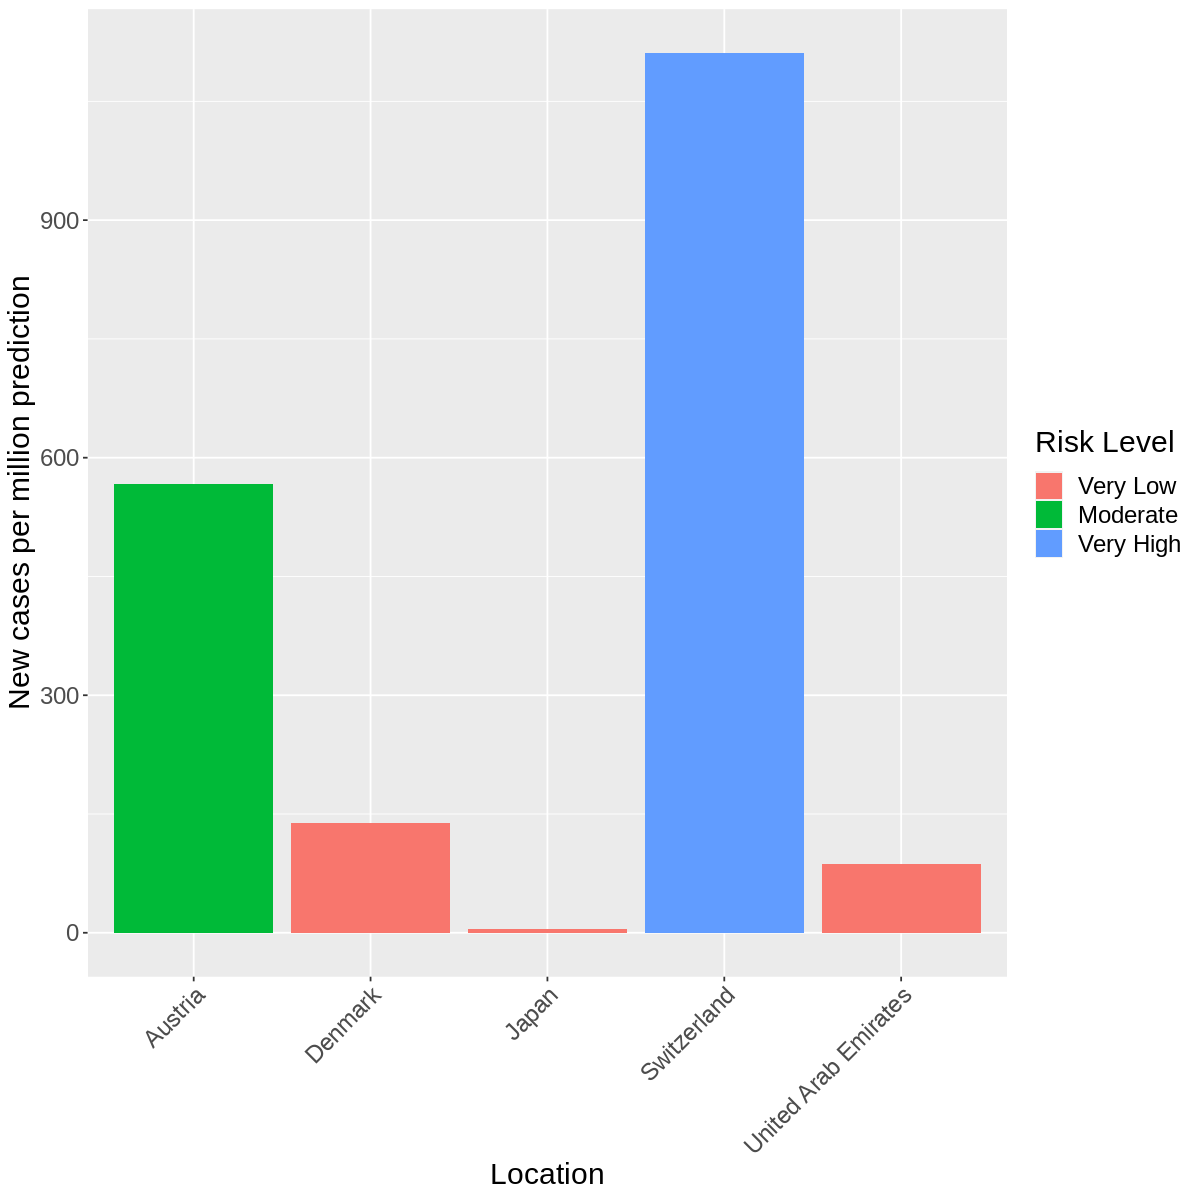

In [ ]:
#final predictions for Billy
final_predictions <- optimized_workflow %>%
  predict(new_obs_all) %>%
    bind_cols(new_obs_all) %>%
    select(location, .pred) %>%
    arrange(.pred)

#adding back the labels from prior in order to qualitatively determine the risk of each location
prediction_risk_level <- final_predictions$.pred %>%
  cut(breaks = c(0,198,395,593,790,1200), labels = c("Very Low", "Low", "Moderate", "High", "Very High"))

final_predictions$prediction_risk_level <- prediction_risk_level

#adding table title
h3("Table 11: Final results for Billy's chosen countries") 
final_predictions

#bar graph of prediction against true value
final_predictions_bar <- final_predictions %>%
  ggplot(aes(x = location, y = .pred, fill = prediction_risk_level)) + 
  geom_bar(stat = "identity") +
  labs(x = "Location", y = "New cases per million prediction", fill = "Risk Level") + 
  theme(text = element_text(size = 18), axis.text.x = element_text(angle = 45, hjust = 1))

#adding figure title
h3("Figure 5: Visualizing Billy's predictions with risk level")
final_predictions_bar

The results are in, and Billy has booked his plane ticket to Japan. We can see from the predictions that Japan is predicted to have the lowest new_cases_per_million on November 17th, 2020, therefore deeming it a worthy candidate for Billy to go and find a job. Since infection rates are very low in comparision to locations such as Switzerland, Billy is confident that he will be able to find work since more people are spending money within the local scene, and are less scared about contracting the virus. Furthermore, although the labels predict that Japan, United Arab Emirates, and Denmark are all classified as 'Very Low', we can see that Japan is very much lower than the other two, thus making it a no brainer for Billy. There is only one issue though, Billy spent so much time tinkering with this model that he has forgotten to open up his Japanese dictionary, so he will be in for a treat upon asking for directions at the airport. 

#**Discussion**

Using new observations from five countries of Billy’s interest, our model predicted that Japan had the lowest number of cases per million (4.4), followed by the United Arab Emirates (87.4). These values both fall within the ‘Very Low’ risk level category. This suggests that it is relatively safe for Billy to move to either Japan or the United Arab Emirates. Given the comparatively low number of cases in Japan over the past few months (Ritchie 2020), the low number of COVID-related deaths (Wingfield-Hayes, 2020), and the high quantity of hospital beds per thousand, this might be expected. However, a very recent surge in COVID-19 cases in Japan (Takashi 2020) could threaten this prediction if this outbreak is not controlled in the future. It would therefore be an interesting future question to predict the upcoming trajectory of cases, instead of simply case numbers, for a more accurate risk assessment and for the future of our buddy Billy.


**References**

Ritchie, H. (2020) Coronavirus Source Data [Data set]. OWID - University of Oxford. https://ourworldindata.org/coronavirus-source-data

Wingfield-Hayes, R. (2020). Coronavirus: Japan’s mysteriously low virus death rate. BBC News. https://www.bbc.com/news/world-asia-53188847

Takahasi, R. (November 18, 2020). Tokyo to raise alert as Japan sets daily record with 2000-plus COVID-19 cases. The Japan Times. https://www.japantimes.co.jp/news/2020/11/18/national/tokyo-coronavirus-alert-level